In [1]:
import time
import joblib
import warnings
import requests
import multiprocessing
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
warnings.filterwarnings("ignore")

In [28]:
def progressBar(iterable, prefix='', suffix='', decimals=1, length=100, fill='█', printEnd="\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    total = len(iterable)
    # Progress Bar Printing Function
    def printProgressBar(iteration):
        percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
        filledLength = int(length * iteration // total)
        bar = fill * filledLength + '-' * (length - filledLength)
        print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Initial Call
    printProgressBar(0)
    # Update Progress Bar
    for i, item in enumerate(iterable):
        yield item
        printProgressBar(i + 1)
    # Print New Line on Complete
    print()

In [57]:
import grequests

class AsynchronousCrawler:
    def __init__(self, lst):
        self.urls = lst

    def exception(self, request, exception):
        print("Problem: {}: {}".format(request.url, exception))

    def asynchronous(self):
        return grequests.map((grequests.get(u) for u in self.urls), exception_handler=self.exception, size=5)

    def collate_responses(self, results):
        return [self.parse(x.text)for x in results if x is not None]

    def parse(self, response_text):
        soup = BeautifulSoup(response_text, "html.parser")
        paragraph = []
        for element in soup.find_all("p"):
            paragraph.append("".join(element.find_all(text=True)))
        return "".join(paragraph[1:-2])

In [20]:
data = joblib.load("../data/sp500_top100_content_v2.bin")
data = data.drop_duplicates(subset="title")
data = data.drop_duplicates(subset="url")
data = data.iloc[:, 0:5]
print(data.shape)
data.head()

(97321, 5)


,title,date,query,url,ticker
0,BRIEF-Apple Inc Says Not Allowing Entertainmen...,2020-03-15,Apple Inc.,https://www.reuters.com/article/idUSFWN2B61K2,AAPL
1,Apple signs multi-year deals with major music ...,2020-03-12,Apple Inc.,https://www.reuters.com/article/idUSKBN20Z33J,AAPL
2,Apple signs multi-year deals with major music ...,2020-03-12,Apple Inc.,https://www.reuters.com/article/idUSL4N2B54T2,AAPL
3,Chinese regulators remove 'Plague Inc' game fr...,2020-02-28,Apple Inc.,https://www.reuters.com/article/idUSKCN20M043,AAPL
4,UPDATE 1-Chinese regulators remove 'Plague Inc...,2020-02-28,Apple Inc.,https://www.reuters.com/article/idUSL3N2AS0OO,AAPL


In [58]:
%%time
ticker = "JNJ"
crawler = AsynchronousCrawler(data[data["ticker"] == ticker].url.tolist())
results = crawler.asynchronous()
contents = crawler.collate_responses(results)

content_list = []
for content, url in zip(contents, data[data["ticker"] == ticker].url.tolist()):
    content_list.append([content, url])
final_df = pd.merge(data, pd.DataFrame(content_list, columns=["content", "url"]), on="url")
joblib.dump(final_df, "../data/tickerdata/{}.bin".format(ticker), compress=5)

Traceback (most recent call last):
  File "C:\Users\jimmy\anaconda3\envs\wj\lib\site-packages\urllib3\contrib\pyopenssl.py", line 488, in wrap_socket
    cnx.do_handshake()
  File "C:\Users\jimmy\anaconda3\envs\wj\lib\site-packages\OpenSSL\SSL.py", line 1934, in do_handshake
    self._raise_ssl_error(self._ssl, result)
  File "C:\Users\jimmy\anaconda3\envs\wj\lib\site-packages\OpenSSL\SSL.py", line 1646, in _raise_ssl_error
    raise WantReadError()
OpenSSL.SSL.WantReadError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "src\\gevent\\greenlet.py", line 854, in gevent._gevent_cgreenlet.Greenlet.run
  File "C:\Users\jimmy\anaconda3\envs\wj\lib\site-packages\grequests.py", line 75, in send
    self.url, **merged_kwargs)
  File "C:\Users\jimmy\anaconda3\envs\wj\lib\site-packages\requests\sessions.py", line 533, in request
    resp = self.send(prep, **send_kwargs)
  File "C:\Users\jimmy\anaconda3\envs\wj\lib\site-packages\req

KeyboardInterrupt: 

In [78]:
import glob

data = pd.DataFrame()
files = [file for file in glob.glob("../data/tickerdata/*.bin")]
for file_name in files:
    print(file_name)
    df = joblib.load(file_name)
    data = pd.concat([data, df], axis=0)
    
data = data.drop_duplicates("title")
data = data.drop_duplicates("url")
data = data.drop_duplicates("content")
data = data.iloc[:, 0:6]

../data/tickerdata\AAPL.bin
../data/tickerdata\ADBE.bin
../data/tickerdata\AMZN.bin
../data/tickerdata\GOOG.bin
../data/tickerdata\T.bin


In [81]:
data

,title,date,query,url,ticker,content
0,BRIEF-Apple Inc Says Not Allowing Entertainmen...,2020-03-15,Apple Inc.,https://www.reuters.com/article/idUSFWN2B61K2,AAPL,March 14 (Reuters) - Apple Inc: * APPLE INC SA...
1,Apple signs multi-year deals with major music ...,2020-03-12,Apple Inc.,https://www.reuters.com/article/idUSKBN20Z33J,AAPL,(Reuters) - Apple Inc has sealed multi-year li...
3,Chinese regulators remove 'Plague Inc' game fr...,2020-02-28,Apple Inc.,https://www.reuters.com/article/idUSKCN20M043,AAPL,BEIJING/SHANGHAI (Reuters) - The video game “P...
5,Apple launches new MacBook Pro,2020-05-04,Apple Inc.,https://www.reuters.com/article/idUSL4N2CM29Z,AAPL,May 4 (Reuters) - Apple Inc on Monday launched...
6,Broadcom to supply wireless components to Apple,2020-01-23,Apple Inc.,https://www.reuters.com/article/idUSKBN1ZM32H,AAPL,(Reuters) - Chipmaker Broadcom Inc (AVGO.O) sa...
...,...,...,...,...,...,...
15214,US STOCKS-Futures point to lower open amid dea...,2014-06-11,"Amazon.com, Inc.",https://www.reuters.com/article/idUSL2N0OS0JA2...,AMZN,* Dow closed at fourth straight record on Tues...
15215,"UPDATE 2-Top Alibaba execs, investors may expa...",2014-07-12,"Amazon.com, Inc.",https://www.reuters.com/article/idUSL2N0PM26Y2...,AMZN,(Adds Alibaba’s estimate of company’s value) B...
15216,PRESS DIGEST- British Business - July 1,2015-07-01,"Amazon.com, Inc.",https://www.reuters.com/article/idUSL3N0ZG5QY2...,AMZN,The following are the top stories on the busin...
15219,UPDATE 2-Groupon forecasts quarterly loss on h...,2014-02-20,"Amazon.com, Inc.",https://www.reuters.com/article/idUSL3N0LP57V2...,AMZN,"(Adds details from conference call, updates sh..."


In [82]:
joblib.dump(data, "../data/sp500_top100_content_base_v1.bin", compress=5)

['../data/sp500_top100_content_base_v1.bin']

In [2]:
from data_process import transform

data = joblib.load("../data/sp500_top100_content_base_v1.bin")
result_df = transform(data)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jimmy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Sparsity Ratio: 0.20893970893970895


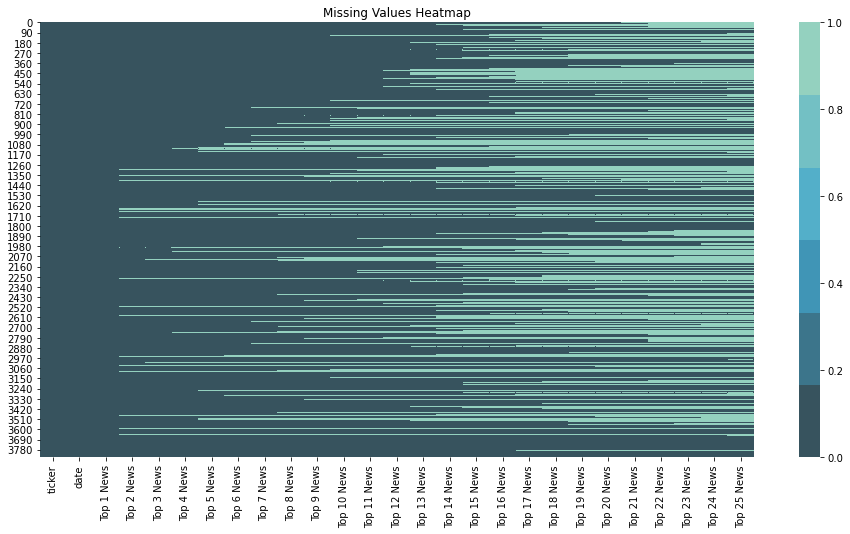

In [3]:
from data_process import check_nan

check_nan(result_df)

In [4]:
import yfinance as yf

def load_stock(ticker_name, start_date="2012-01-01"):
    ticker = yf.Ticker(ticker_name)
    hist = ticker.history(period="max", start=start_date)
    hist.index = hist.index.set_names(['date'])
    hist = hist.reset_index(drop=False, inplace=False)
    hist["date"] = pd.to_datetime(hist["date"], utc=True)
    hist['date'] = hist['date'].apply(lambda x: x.date())
    hist.sort_values(by='date', inplace=True)
    hist.reset_index(drop=True, inplace=True)
    hist["ticker"] = ticker_name
    hist["label"] = hist["Close"].diff(periods=1)
    hist.dropna(inplace=True)
    hist["label"] = hist["label"].map(lambda x: 1 if float(x) >= 0 else 0)
    return hist

In [7]:
TRAIN_START_DATE = "2012-01-01"
TRAIN_END_DATE = "2015-12-31"
VALID_START_DATE = "2016-01-01"
VALID_END_DATE = "2016-12-31"
TEST_START_DATE = "2017-01-01"
TEST_END_DATE = "2020-07-01"

train = pd.DataFrame()
valid = pd.DataFrame()
test = pd.DataFrame()

news_all = result_df

for ticker in tqdm(news_all["ticker"].unique()):
    news = news_all[news_all["ticker"] == str(ticker)]
    stock = load_stock(str(ticker), start_date="2012-01-01")
    news_and_stock = pd.merge(news, stock, on=["date"])
    news_and_stock.set_index('date', inplace=True)
    news_and_stock = news_and_stock.sort_index()
    
    train_temp = news_and_stock.loc[
        pd.to_datetime(TRAIN_START_DATE).date():pd.to_datetime(TRAIN_END_DATE).date()]
    valid_temp = news_and_stock.loc[
        pd.to_datetime(VALID_START_DATE).date():pd.to_datetime(VALID_END_DATE).date()]
    test_temp = news_and_stock.loc[
        pd.to_datetime(TEST_START_DATE).date():pd.to_datetime(TEST_END_DATE).date()]
    
    train = pd.concat([train, train_temp], axis=0)
    valid = pd.concat([valid, valid_temp], axis=0)
    test = pd.concat([test, test_temp], axis=0)

In [9]:
train = train.iloc[:, 1:]
joblib.dump(train, "../data/train_top25.bin", compress=3)
valid = valid.iloc[:, 1:]
joblib.dump(valid, "../data/valid_top25.bin", compress=3)
test = test.iloc[:, 1:]
joblib.dump(test, "../data/test_top25.bin", compress=3)

['../data/test_top25.bin']

In [10]:
data.ticker.unique()

array(['AAPL', 'ADBE', 'MSFT', 'AMZN'], dtype=object)